# Load dataset & preprocessing

In [1]:
import pandas as pd
import numpy as np

root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
exp_dir = "datasets/infuluenza/LSTM/"

df = pd.read_csv(data_path)

/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_tokyo = df[df['regnames'].isin(["Tokyo"])]

df_tokyo.head()

,Alltime,Time,region,regnames,Longitude,Latitude,Altitude,Year,Month,Week,Flucases,Holiday,Tempave,Tempmin,Tempmax,Rh
12480,12481,1,13,Tokyo,35.689185,139.691648,34.9,2000,1,1,818,2,9.528571,6.371429,13.385714,50.571429
12481,12482,2,13,Tokyo,35.689185,139.691648,34.9,2000,1,2,1167,3,8.642857,5.457143,12.000000,61.142857
12482,12483,3,13,Tokyo,35.689185,139.691648,34.9,2000,1,3,2562,2,6.828571,4.171429,9.500000,56.000000
12483,12484,4,13,Tokyo,35.689185,139.691648,34.9,2000,1,4,3781,2,5.342857,1.542857,9.400000,42.000000
12484,12485,5,13,Tokyo,35.689185,139.691648,34.9,2000,1,5,3903,2,7.214286,3.171429,11.585714,38.714286


In [3]:
train_n = int(len(df_tokyo["Flucases"])*0.75)
test_n = int(len(df_tokyo["Flucases"])*0.25)
train_n, test_n

(780, 260)

In [4]:
train_steps = np.arange(train_n)
test_steps = np.arange(train_n,train_n + test_n)

In [5]:
columns = ["Flucases","Tempave", "Rh", "Holiday"]

all_data = df_tokyo[columns]

In [6]:
train_df = all_data[columns][0:train_n]
test_df = all_data[columns][train_n:train_n+test_n]

In [7]:
train_df.head()

,Flucases,Tempave,Rh,Holiday
12480,818,9.528571,50.571429,2
12481,1167,8.642857,61.142857,3
12482,2562,6.828571,56.000000,2
12483,3781,5.342857,42.000000,2
12484,3903,7.214286,38.714286,2


In [8]:
test_df.head()

,Flucases,Tempave,Rh,Holiday
13260,3809,5.357143,47.142857,3
13261,9892,6.285714,38.285714,2
13262,8198,5.628571,53.857143,3
13263,9625,6.771429,63.714286,2
13264,7844,4.228571,49.000000,2


trainとtestのdfを作る

In [9]:
train_ts_df = train_df["Flucases"]
train_ys_df = train_df[["Tempave", "Rh"]]
train_xs_df = train_df["Holiday"]

test_ts_df = test_df["Flucases"]
test_ys_df = test_df[["Tempave", "Rh"]]
test_xs_df = test_df["Holiday"]

In [10]:
seq_length = 13

# Dataset and DataLoader

In [11]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
import torch.nn as nn
from torch.nn import Sequential, Linear, Tanh, Sigmoid, LeakyReLU, ReLU
import torch.nn.functional as F
import torch.optim as optim

import numpy as np #数値計算用ライブラリ
import matplotlib.pyplot as plt #描画用ライブラリ

In [12]:
root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
data_dir = "datasets/infuluenza/vecLSTMx/"
exp_dir = "datasets/infuluenza/LSTM/"

In [13]:
import joblib

# スケーラーの読み込み
std_scaler = joblib.load(data_dir + 'std_scaler.joblib')

In [14]:
train_Xs = np.load(data_dir + "train_Xs_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_ys_" + str(seq_length) + "w.npy")
val_Xs = np.load(data_dir + "val_Xs_" + str(seq_length) + "w.npy")
val_ys = np.load(data_dir + "val_ys_" + str(seq_length) + "w.npy")

In [15]:
trn_xs_tensor = torch.Tensor(train_Xs[:,:,0:1])
trn_ys_tensor = torch.Tensor(train_ys[:,:,0:1])

val_xs_tensor = torch.Tensor(val_Xs[:,:,0:1])
val_ys_tensor = torch.Tensor(val_ys[:,:,0:1])

In [16]:
trn_xs_tensor.shape, trn_ys_tensor.shape, val_xs_tensor.shape, val_ys_tensor.shape

(torch.Size([613, 13, 1]),
 torch.Size([613, 1, 1]),
 torch.Size([154, 13, 1]),
 torch.Size([154, 1, 1]))

In [17]:
from torch.utils.data import TensorDataset, DataLoader

trn_dataset = TensorDataset(trn_xs_tensor, trn_ys_tensor)
trn_loader = DataLoader(dataset=trn_dataset,batch_size=50,shuffle=True)

val_dataset = TensorDataset(val_xs_tensor, val_ys_tensor)
val_loader = DataLoader(dataset=val_dataset,batch_size=50,shuffle=False)

In [18]:
for id, batch_data in enumerate(trn_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
1 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
2 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
3 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
4 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
5 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
6 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
7 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
8 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
9 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
10 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
11 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
12 torch.Size([13, 13, 1]) torch.Size([13, 1, 1])


In [19]:
for id, batch_data in enumerate(val_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
1 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
2 torch.Size([50, 13, 1]) torch.Size([50, 1, 1])
3 torch.Size([4, 13, 1]) torch.Size([4, 1, 1])


# LSTM model

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size=32, output_size=1, num_layers = 2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = num_layers
        
        self.relu = ReLU()
        self.lrelu = LeakyReLU(negative_slope=0.01)
        
        # input_sizeは入力する次元数
        self.lstm = nn.LSTM(input_size=self.input_size, num_layers=self.n_layers, hidden_size=self.hidden_size, dropout=0.2)
        
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size * 4)
        self.fc2 = nn.Linear(self.hidden_size * 4, self.output_size)


    def forward(self, x):
        last_outs, hidden = self.lstm(x) #(batch_size, seq_len, hidden)
        outs = last_outs[:, -1, :] #(batch_size, hidden)
 
        h = self.relu(self.fc1(outs))
        y = self.relu(self.fc2(h))

        return y

In [21]:
model = LSTM(input_size = 1, hidden_size = 16, output_size = 1, num_layers = 1)

/home/is/daiki-ko/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Prediction

In [22]:
batch_0x = list(trn_loader)[0][0]

In [23]:
batch_0x.shape

torch.Size([50, 13, 1])

In [24]:
preds = model(batch_0x)

In [25]:
preds.shape

torch.Size([50, 1])

## Train

In [26]:
model.cuda()

LSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(1, 16, dropout=0.2)
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [27]:
criterion = nn.MSELoss(reduction='mean').cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [28]:
def val_model(epoch):
    
    model.eval()
    
    sum_errors = 0
    
    for batch_data in val_loader:
       
        with torch.no_grad():
            
            if torch.cuda.is_available():
                inputs, trues = batch_data
                inputs, trues = inputs.cuda(), trues.cuda()

            preds = model(inputs)
            true_y = trues.reshape(preds.shape)
            loss = criterion(preds, true_y)
            
            sum_errors = sum_errors + loss.data.item()

            del loss
            torch.cuda.empty_cache()
            
    return sum_errors / len(val_loader)

In [29]:
train_loss_hist = []
val_loss_hist = []
best_loss = 1e10
n_epochs = 500

for epoch in range(n_epochs):
    
    model.train()
    train_loss = 0
    
    for batch_data in trn_loader:
        
        inputs, trues = batch_data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        optimizer.zero_grad()
        
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        loss = criterion(preds, true_y)
        
        loss.backward() #偏微分を計算
        
        train_loss += loss.item()

        #パラメータを更新する
        optimizer.step()
    
    val_loss = val_model(epoch)
    train_loss_hist.append(train_loss / len(trn_loader))
    val_loss_hist.append(val_loss)
    
    print("epoch: ", epoch, "Train loss: ", train_loss / len(trn_loader), "Val loss: ", val_loss)
    
    if val_loss < best_loss:
        save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"
        torch.save(model, save_model_path)
        best_loss = val_loss

epoch:  0 Train loss:  0.9300511261591544 Val loss:  0.25000346079468727
epoch:  1 Train loss:  0.8291650850039262 Val loss:  0.24555113911628723
epoch:  2 Train loss:  0.7915478279957404 Val loss:  0.2325883712619543
epoch:  3 Train loss:  0.7488720726508361 Val loss:  0.20697698928415775
epoch:  4 Train loss:  0.6537355224673564 Val loss:  0.17518768832087517
epoch:  5 Train loss:  0.5783205926418304 Val loss:  0.1382098738104105
epoch:  6 Train loss:  0.44192057446791577 Val loss:  0.09459645673632622
epoch:  7 Train loss:  0.31459080886382323 Val loss:  0.06688642594963312
epoch:  8 Train loss:  0.21652007962648684 Val loss:  0.05760660348460078
epoch:  9 Train loss:  0.12748651579022408 Val loss:  0.07415193784981966
epoch:  10 Train loss:  0.11777447937772824 Val loss:  0.08239041501656175
epoch:  11 Train loss:  0.10934996640739533 Val loss:  0.06955012073740363
epoch:  12 Train loss:  0.1183700216217683 Val loss:  0.07216747337952256
epoch:  13 Train loss:  0.111066513050061 Va

epoch:  112 Train loss:  0.109534705344301 Val loss:  0.04915257517131977
epoch:  113 Train loss:  0.11063408894607654 Val loss:  0.056729092244495405
epoch:  114 Train loss:  0.12872487005706018 Val loss:  0.05917982629034668
epoch:  115 Train loss:  0.12653541615089545 Val loss:  0.05353489864501171
epoch:  116 Train loss:  0.11295846663415432 Val loss:  0.051744535710895434
epoch:  117 Train loss:  0.11744661421443407 Val loss:  0.05191283345629927
epoch:  118 Train loss:  0.10596065008296417 Val loss:  0.062259849975816905
epoch:  119 Train loss:  0.11755338941629116 Val loss:  0.0564797900551639
epoch:  120 Train loss:  0.10882431300034603 Val loss:  0.05718179410905577
epoch:  121 Train loss:  0.1085470007159389 Val loss:  0.0535055505897617
epoch:  122 Train loss:  0.10929740162996146 Val loss:  0.053619038983015344
epoch:  123 Train loss:  0.10718095033259417 Val loss:  0.050733323358144844
epoch:  124 Train loss:  0.10407448735517952 Val loss:  0.054243341694018454
epoch:  125

epoch:  223 Train loss:  0.12067366083367513 Val loss:  0.05367864265826938
epoch:  224 Train loss:  0.1116438487974497 Val loss:  0.05338125004800531
epoch:  225 Train loss:  0.10559499518086131 Val loss:  0.055753666249984235
epoch:  226 Train loss:  0.10791587872573963 Val loss:  0.05289330662526481
epoch:  227 Train loss:  0.10519869496616033 Val loss:  0.05228893299954507
epoch:  228 Train loss:  0.13218399939628747 Val loss:  0.05284067454886099
epoch:  229 Train loss:  0.10984544943158443 Val loss:  0.05573458717572066
epoch:  230 Train loss:  0.11292695506619146 Val loss:  0.056688406312787265
epoch:  231 Train loss:  0.10569020554136771 Val loss:  0.060284363701612165
epoch:  232 Train loss:  0.12823093481934988 Val loss:  0.0549531148690221
epoch:  233 Train loss:  0.10592622510515727 Val loss:  0.05886315768020722
epoch:  234 Train loss:  0.10973817367966358 Val loss:  0.053361583774858445
epoch:  235 Train loss:  0.10690517458491601 Val loss:  0.0558217621910444
epoch:  236

epoch:  332 Train loss:  0.10693693633836049 Val loss:  0.05383043484198424
epoch:  333 Train loss:  0.106633260487937 Val loss:  0.053013264009678096
epoch:  334 Train loss:  0.11324730730400635 Val loss:  0.051373808918469877
epoch:  335 Train loss:  0.1061756840118995 Val loss:  0.05127307287784788
epoch:  336 Train loss:  0.10544643708719657 Val loss:  0.052243705647015304
epoch:  337 Train loss:  0.10591269155534414 Val loss:  0.05370362456324074
epoch:  338 Train loss:  0.11003725803815402 Val loss:  0.050666170934164256
epoch:  339 Train loss:  0.10922702824553618 Val loss:  0.05050344110054539
epoch:  340 Train loss:  0.10997596748459798 Val loss:  0.05638598583982457
epoch:  341 Train loss:  0.11057693726168229 Val loss:  0.05271176183032367
epoch:  342 Train loss:  0.10994469352926199 Val loss:  0.05006617800700042
epoch:  343 Train loss:  0.10620767128868745 Val loss:  0.05084405866818997
epoch:  344 Train loss:  0.1059818767870848 Val loss:  0.05925075066897989
epoch:  345 

epoch:  440 Train loss:  0.1198501754552126 Val loss:  0.05287221753405902
epoch:  441 Train loss:  0.10534319781268445 Val loss:  0.05775390096459887
epoch:  442 Train loss:  0.10482899407641245 Val loss:  0.05452510046598036
epoch:  443 Train loss:  0.10468948926203527 Val loss:  0.053620383382622094
epoch:  444 Train loss:  0.1086325032923084 Val loss:  0.05189080041418492
epoch:  445 Train loss:  0.10478048492223024 Val loss:  0.0548056162224384
epoch:  446 Train loss:  0.10598238712722938 Val loss:  0.05333855515027608
epoch:  447 Train loss:  0.10495792666020301 Val loss:  0.054458793809317285
epoch:  448 Train loss:  0.10731691902933213 Val loss:  0.053041330505038786
epoch:  449 Train loss:  0.11226523094452344 Val loss:  0.05426007857749937
epoch:  450 Train loss:  0.10587033324946578 Val loss:  0.053509169087192276
epoch:  451 Train loss:  0.12867516264892542 Val loss:  0.05225005364991375
epoch:  452 Train loss:  0.10556861521819463 Val loss:  0.0509345923201181
epoch:  453 

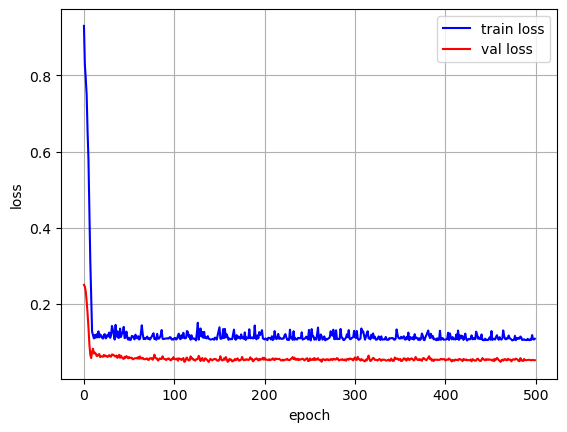

In [30]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_hist)), train_loss_hist, c='b', label='train loss')
plt.plot(range(len(val_loss_hist)), val_loss_hist, c='r', label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

In [31]:
np.argmin(val_loss_hist), np.min(val_loss_hist)

(138, 0.04762444029256585)

In [32]:
save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"

model = torch.load(save_model_path)

### Scatter plot

In [33]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(trn_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [34]:
np.array(trues_list).shape, np.array(preds_list).shape

((613, 1, 1), (613, 1, 1))

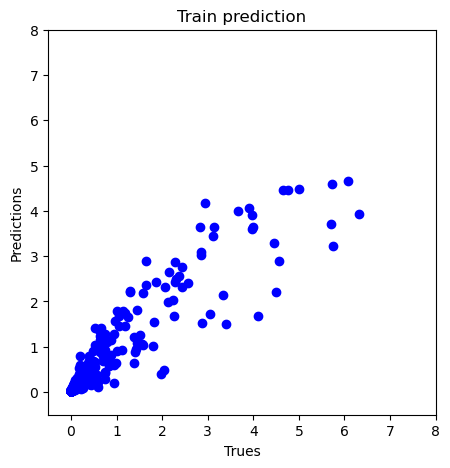

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Train prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

In [36]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(val_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


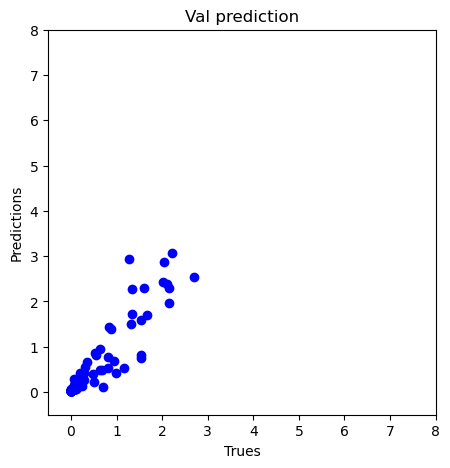

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Val prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

## Test prediction

In [38]:
#test_np = np.concatenate([test_ts_np.reshape(-1,1), test_ys_np, test_xs_np.reshape(-1,1)], axis = 1)

train_np = np.load(data_dir + "train_np.npy")
test_np = np.load(data_dir + "test_np.npy")

In [39]:
train_np.shape, test_np.shape

((780, 4), (260, 4))

In [40]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 3e5

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 100

test_scaled_ts = (np.array(test_np[:,0]) - dat_min) / (dat_max - dat_min) * (custom_max - custom_min) + custom_min

In [41]:
test_scaled_ys = std_scaler.transform(test_np[:,1:3])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [42]:
test_scaled_ys.shape, test_scaled_ts.reshape(-1,1).shape, test_np[:,-1].shape

((260, 2), (260, 1), (260,))

In [43]:
test_all_np = np.concatenate([test_scaled_ts.reshape(-1,1), test_scaled_ys, test_np[:,-1].reshape(-1,1)], axis = 1)

In [44]:
test_all_np.shape

(260, 4)

In [45]:
test_np[:,-1].shape, test_scaled_ts.shape, test_scaled_ys.shape, test_np.shape

((260,), (260,), (260, 2), (260, 4))

### 1. Prediction based on results from 40 days ago

In [46]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, seq_size: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """データをsequence_sizeに指定したサイズのシーケンスに分けてシーケンスとその答えをarrayで返す
    Args:
        data (np.ndarray): 入力データ
        seq_size (int): シーケンスサイズ
    Returns:
        seq_arr: seq_sizeに指定した数のシーケンスを格納するarray
        target_arr: シーケンスに対応する答えを格納するarray
    """

    num_data = len(data)
    seq_data = []
    target_data = []
    
    for i in range(num_data - seq_size):
        seq_data.append(data[i:i+seq_size])
        target_data.append(data[i+seq_size:i+seq_size+1])
        
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [47]:
test_Xs, test_ys = make_sequence_data(test_all_np, seq_length)

In [48]:
test_Xs.shape, test_ys.shape

((247, 13, 4), (247, 1, 4))

In [49]:
tst_xs_tensor = torch.Tensor(test_Xs[:,:,0:1])
tst_ys_tensor = torch.Tensor(test_ys[:,:,0:1])

In [50]:
from torch.utils.data import TensorDataset, DataLoader

tst_dataset = TensorDataset(tst_xs_tensor, tst_ys_tensor)

In [51]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(tst_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246


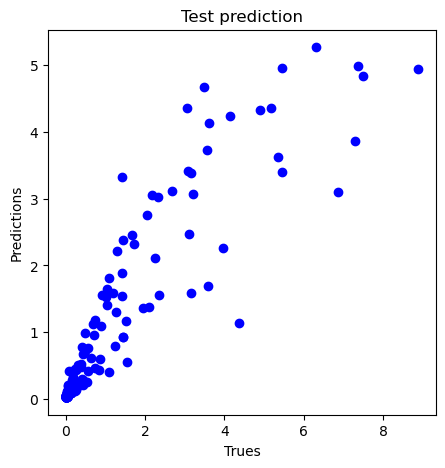

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Test prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [53]:
tst_trues, tst_preds = np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0]

In [54]:
tst_preds = (np.array(preds_list)[:,:,0] - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min

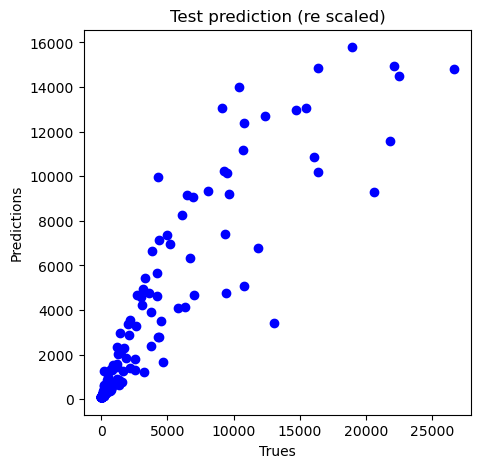

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(test_np[seq_length:,0], tst_preds, c = "b") # 散布図を描画
plt.title("Test prediction (re scaled)")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [56]:
tst_preds.shape

(247, 1)

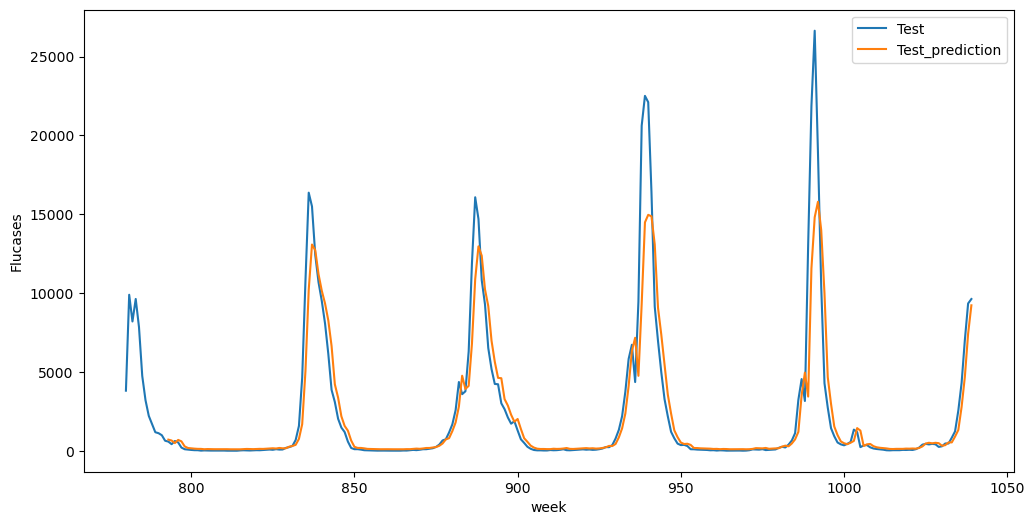

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n],label="Test")
plt.plot(test_steps[seq_length:], tst_preds,label="Test_prediction")

plt.xlabel("week")
plt.ylabel("Flucases")
plt.legend()

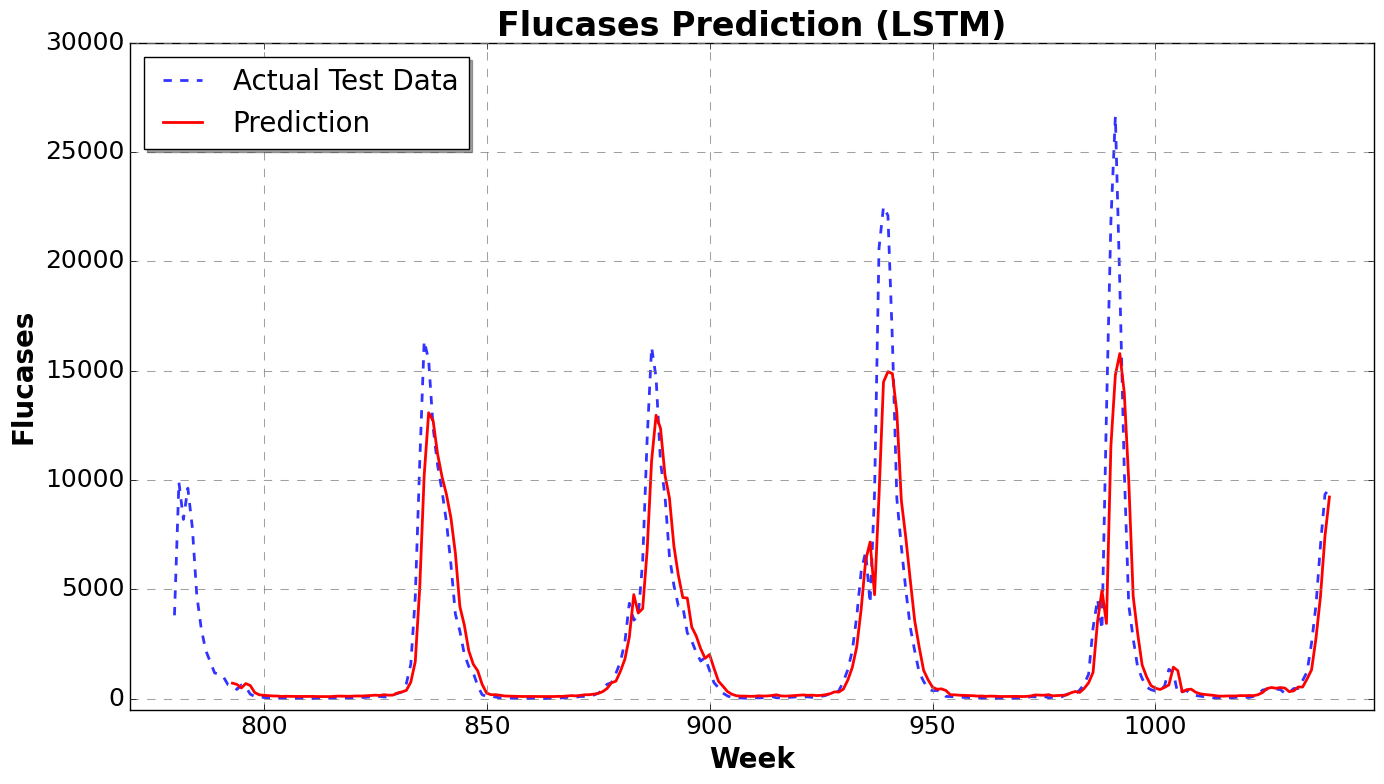

In [58]:
plt.figure(figsize=(14, 8))
plt.style.use('classic')  # スタイリッシュな背景に変更

# 実際のデータと予測データをプロット
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n], label="Actual Test Data", linestyle='--', linewidth=2, color='blue', alpha=0.8)
plt.plot(test_steps[seq_length:], tst_preds, label="Prediction", linestyle='-', linewidth=2, color='red', alpha=1.0)

# 軸ラベルとタイトルを追加
plt.xlabel("Week", fontsize=20, fontweight='bold')
plt.ylabel("Flucases", fontsize=20, fontweight='bold')
plt.title("Flucases Prediction (LSTM)", fontsize=24, fontweight='bold')

# グリッドの調整
plt.grid(color='gray', linestyle='--', linewidth=0.75, alpha=0.75)

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# 凡例の調整
plt.legend(fontsize=20, loc='upper left', frameon=True, shadow=True)
plt.ylim(bottom=-500)
plt.xlim(left=min(test_steps) - 10, right = max(test_steps) + 10)

# 仕上げ
plt.tight_layout()
plt.show()

In [59]:
from sklearn.metrics import (
    mean_squared_error,  # MSE
    mean_absolute_error,  # MAE
    r2_score, # R2
)

from scipy.stats import pearsonr

def reg_metric(trues, preds, name):
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    r, p = pearsonr(trues, preds)
    
    print(name)
    print(f'MSE : {mse}.')
    print(f'RMSE : {rmse}.')
    print(f'MAE : {mae}.')
    print(f'R2 : {r2}.')
    print("pearson :", r, p)

In [60]:
reg_metric(test_np[seq_length*4:,0], tst_preds[seq_length*3:,0], "Flucases")

Flucases
MSE : 4478548.044494397.
RMSE : 2116.2580288080176.
MAE : 927.7085519203773.
R2 : 0.8142705142898614.
pearson : 0.912937998769936 3.991760546159595e-82
